# Experiment 9: Artificial Neural Network (ANN) Classifier
## Building a Neural Network from Scratch


## Task 1: Data Loading and Preprocessing

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X = data.data
y = data.target

print("Dataset loaded successfully!")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"\nFeature names:\n{data.feature_names}")
print(f"\nTarget names: {data.target_names}")
print(f"This is a binary classification problem: 0 = {data.target_names[0]}, 1 = {data.target_names[1]}")

Dataset loaded successfully!
Shape of X: (569, 30)
Shape of y: (569,)

Feature names:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target names: ['malignant' 'benign']
This is a binary classification problem: 0 = malignant, 1 = benign


In [3]:
# Create 70/30 train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validation set shape: X_val {X_val.shape}, y_val {y_val.shape}")

Training set size: 398 samples
Validation set size: 171 samples
Training set shape: X_train (398, 30), y_train (398,)
Validation set shape: X_val (171, 30), y_val (171,)


In [4]:
# Standardize features (critical for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data only
X_val_scaled = scaler.transform(X_val)  # Transform validation data using training statistics

print("Feature standardization complete!")
print(f"X_train_scaled mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")
print(f"X_val_scaled mean: {X_val_scaled.mean():.6f}, std: {X_val_scaled.std():.6f}")

Feature standardization complete!
X_train_scaled mean: -0.000000, std: 1.000000
X_val_scaled mean: 0.031710, std: 1.024241


## Task 2: 'From Scratch' Utilities (NumPy)

In [ ]:
# Activation Functions
def sigmoid(Z):
    """Compute the sigmoid activation function"""
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    """Compute the ReLU activation function"""
    return np.maximum(0, Z)

# Activation Derivatives
def sigmoid_derivative(A):
    return A * (1 - A)

def relu_derivative(Z):
    return (Z > 0).astype(float)

# Loss Functions
def compute_bce_loss(Y, Y_hat):

    m = Y.shape[1]
    epsilon = 1e-15  # For numerical stability
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)  # Clip values to avoid log(0)
    loss = -np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)) / m
    return loss

def compute_mse_loss(Y, Y_hat):
  
    m = Y.shape[1]
    loss = np.sum((Y_hat - Y) ** 2) / m
    return loss

print("Utility functions implemented successfully!")

Utility functions implemented successfully!


## Task 3: 'From Scratch' ANN Classifier

In [ ]:
class MyANNClassifier:

    
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters = {}
        self.costs = []
        
    def _initialize_parameters(self):
        """Initialize weights and biases for all layers"""
        np.random.seed(42)
        L = len(self.layer_dims)
        
        for l in range(1, L):
            if l < L - 1:  
                self.parameters[f'W{l}'] = np.random.randn(self.layer_dims[l], 
                                                           self.layer_dims[l-1]) * np.sqrt(2.0 / self.layer_dims[l-1])
            else:  
                self.parameters[f'W{l}'] = np.random.randn(self.layer_dims[l], 
                                                           self.layer_dims[l-1]) * np.sqrt(1.0 / self.layer_dims[l-1])
            self.parameters[f'b{l}'] = np.zeros((self.layer_dims[l], 1))
            
        print(f"Parameters initialized for {L-1} layers")
        
    def _forward_propagation(self, X):

        cache = []
        A = X
        L = len(self.parameters) // 2  # Number of layers
        
        # Loop through hidden layers (use ReLU)
        for l in range(1, L):
            A_prev = A
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            
            Z = np.dot(W, A_prev) + b
            A = relu(Z)
            cache.append((A_prev, Z, A))
            
        # Output layer (use Sigmoid)
        A_prev = A
        W = self.parameters[f'W{L}']
        b = self.parameters[f'b{L}']
        
        Z = np.dot(W, A_prev) + b
        A_L = sigmoid(Z)
        cache.append((A_prev, Z, A_L))
        
        return A_L, cache
    
    def _backward_propagation(self, Y, Y_hat, cache):

        grads = {}
        L = len(cache)  # Number of layers
        m = Y.shape[1]
        
        # Initialize backpropagation - compute dA_L based on loss function
        if self.loss == 'bce':
            # Derivative of BCE loss w.r.t. Y_hat
            dA_L = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))
        elif self.loss == 'mse':
            # Derivative of MSE loss w.r.t. Y_hat
            dA_L = 2 * (Y_hat - Y)
        
        # Output layer (Sigmoid activation)
        A_prev, Z_L, A_L = cache[L-1]
        dZ_L = dA_L * sigmoid_derivative(A_L)
        grads[f'dW{L}'] = np.dot(dZ_L, A_prev.T) / m
        grads[f'db{L}'] = np.sum(dZ_L, axis=1, keepdims=True) / m
        dA_prev = np.dot(self.parameters[f'W{L}'].T, dZ_L)
        
        # Loop backwards through hidden layers (ReLU activation)
        for l in reversed(range(L-1)):
            A_prev_l, Z_l, A_l = cache[l]
            
            dZ = dA_prev * relu_derivative(Z_l)
            grads[f'dW{l+1}'] = np.dot(dZ, A_prev_l.T) / m
            grads[f'db{l+1}'] = np.sum(dZ, axis=1, keepdims=True) / m
            
            if l > 0:  # Don't compute dA_prev for the first layer
                dA_prev = np.dot(self.parameters[f'W{l+1}'].T, dZ)
        
        return grads
    
    def _update_parameters(self, grads):

        L = len(self.parameters) // 2
        
        for l in range(1, L + 1):
            self.parameters[f'W{l}'] -= self.learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.learning_rate * grads[f'db{l}']
    
    def fit(self, X, y):

        # Reshape data for proper matrix operations
        X = X.T  # (n_features, m_samples)
        y = y.reshape(1, -1)  # (1, m_samples)
        
        # Initialize parameters
        self._initialize_parameters()
        
        # Training loop
        for i in range(self.n_iterations):
            # Forward propagation
            Y_hat, cache = self._forward_propagation(X)
            
            # Compute loss
            if self.loss == 'bce':
                cost = compute_bce_loss(y, Y_hat)
            else:
                cost = compute_mse_loss(y, Y_hat)
            
            # Backward propagation
            grads = self._backward_propagation(y, Y_hat, cache)
            
            # Update parameters
            self._update_parameters(grads)
            
            # Store cost
            self.costs.append(cost)
            
            # Print progress
            if i % 500 == 0:
                print(f"Iteration {i}/{self.n_iterations}, Cost: {cost:.6f}")
        
        print(f"Training complete! Final cost: {self.costs[-1]:.6f}")
    
    def predict(self, X):
  
        X = X.T  
        
        # Forward propagation
        Y_hat, _ = self._forward_propagation(X)
        
        # Convert probabilities to binary predictions
        predictions = (Y_hat > 0.5).astype(int)

        print("MyANNClassifier class implemented successfully!")

        return predictions.flatten()

## Task 4: Training and Experimentation

### Model 1: BCE Loss with 1 Hidden Layer

In [19]:
# Model 1: BCE Loss, 1 Hidden Layer [30, 10, 1]
print("=" * 60)
print("MODEL 1: BCE Loss with 1 Hidden Layer [30, 10, 1]")
print("=" * 60)

model1 = MyANNClassifier(
    layer_dims=[30, 10, 1],
    learning_rate=0.01,
    n_iterations=5000,
    loss='bce'
)

# Train the model
model1.fit(X_train_scaled, y_train)

# Make predictions on validation set
y_pred_model1 = model1.predict(X_val_scaled)

# Print classification report
print("\n" + "=" * 60)
print("MODEL 1 - Classification Report:")
print("=" * 60)
print(classification_report(y_val, y_pred_model1, target_names=['malignant', 'benign']))

MODEL 1: BCE Loss with 1 Hidden Layer [30, 10, 1]
Parameters initialized for 2 layers
Iteration 0/5000, Cost: 0.742920
Iteration 500/5000, Cost: 0.172053
Iteration 1000/5000, Cost: 0.119338
Iteration 1500/5000, Cost: 0.096693
Iteration 2000/5000, Cost: 0.083988
Iteration 2500/5000, Cost: 0.075496
Iteration 3000/5000, Cost: 0.068846
Iteration 3500/5000, Cost: 0.063058
Iteration 4000/5000, Cost: 0.058264
Iteration 4500/5000, Cost: 0.054396
Training complete! Final cost: 0.051203
MyANNClassifier class implemented successfully!

MODEL 1 - Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        63
      benign       0.99      0.99      0.99       108

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



### Model 2: MSE Loss with 1 Hidden Layer

In [20]:
# Model 2: MSE Loss, 1 Hidden Layer [30, 10, 1]
print("\n" + "=" * 60)
print("MODEL 2: MSE Loss with 1 Hidden Layer [30, 10, 1]")
print("=" * 60)

model2 = MyANNClassifier(
    layer_dims=[30, 10, 1],
    learning_rate=0.01,
    n_iterations=5000,
    loss='mse'
)

# Train the model
model2.fit(X_train_scaled, y_train)

# Make predictions on validation set
y_pred_model2 = model2.predict(X_val_scaled)

# Print classification report
print("\n" + "=" * 60)
print("MODEL 2 - Classification Report:")
print("=" * 60)
print(classification_report(y_val, y_pred_model2, target_names=['malignant', 'benign']))


MODEL 2: MSE Loss with 1 Hidden Layer [30, 10, 1]
Parameters initialized for 2 layers
Iteration 0/5000, Cost: 0.273423
Iteration 500/5000, Cost: 0.080775
Iteration 1000/5000, Cost: 0.055589
Iteration 1500/5000, Cost: 0.045505
Iteration 2000/5000, Cost: 0.039327
Iteration 2500/5000, Cost: 0.035136
Iteration 3000/5000, Cost: 0.031902
Iteration 3500/5000, Cost: 0.029375
Iteration 4000/5000, Cost: 0.027302
Iteration 4500/5000, Cost: 0.025584
Training complete! Final cost: 0.024157
MyANNClassifier class implemented successfully!

MODEL 2 - Classification Report:
              precision    recall  f1-score   support

   malignant       0.97      0.98      0.98        63
      benign       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



### Model 3: BCE Loss with Deeper Architecture (2 Hidden Layers)

In [21]:
# Model 3: BCE Loss, Deeper Architecture [30, 10, 5, 1]
print("\n" + "=" * 60)
print("MODEL 3: BCE Loss with 2 Hidden Layers [30, 10, 5, 1]")
print("=" * 60)

model3 = MyANNClassifier(
    layer_dims=[30, 10, 5, 1],
    learning_rate=0.01,
    n_iterations=5000,
    loss='bce'
)

# Train the model
model3.fit(X_train_scaled, y_train)

# Make predictions on validation set
y_pred_model3 = model3.predict(X_val_scaled)

# Print classification report
print("\n" + "=" * 60)
print("MODEL 3 - Classification Report:")
print("=" * 60)
print(classification_report(y_val, y_pred_model3, target_names=['malignant', 'benign']))


MODEL 3: BCE Loss with 2 Hidden Layers [30, 10, 5, 1]
Parameters initialized for 3 layers
Iteration 0/5000, Cost: 0.664292
Iteration 500/5000, Cost: 0.292583
Iteration 1000/5000, Cost: 0.210873
Iteration 1500/5000, Cost: 0.162867
Iteration 2000/5000, Cost: 0.132639
Iteration 2500/5000, Cost: 0.111510
Iteration 3000/5000, Cost: 0.096582
Iteration 3500/5000, Cost: 0.085601
Iteration 4000/5000, Cost: 0.076919
Iteration 4500/5000, Cost: 0.069828
Training complete! Final cost: 0.063833
MyANNClassifier class implemented successfully!

MODEL 3 - Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.97      0.96        63
      benign       0.98      0.97      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



## Task 5: Comparison with scikit-learn MLPClassifier

In [14]:
# Train sklearn MLPClassifier
print("\n" + "=" * 60)
print("SKLEARN MLPClassifier")
print("=" * 60)

sklearn_model = MLPClassifier(
    hidden_layer_sizes=(10,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    learning_rate_init=0.01,
    random_state=42
)

# Train the model
sklearn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_sklearn = sklearn_model.predict(X_val_scaled)

# Print classification report
print("\n" + "=" * 60)
print("SKLEARN MLPClassifier - Classification Report:")
print("=" * 60)
print(classification_report(y_val, y_pred_sklearn, target_names=['malignant', 'benign']))


SKLEARN MLPClassifier

SKLEARN MLPClassifier - Classification Report:
              precision    recall  f1-score   support

   malignant       0.97      0.98      0.98        63
      benign       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



## Visualization: Loss Curves Comparison

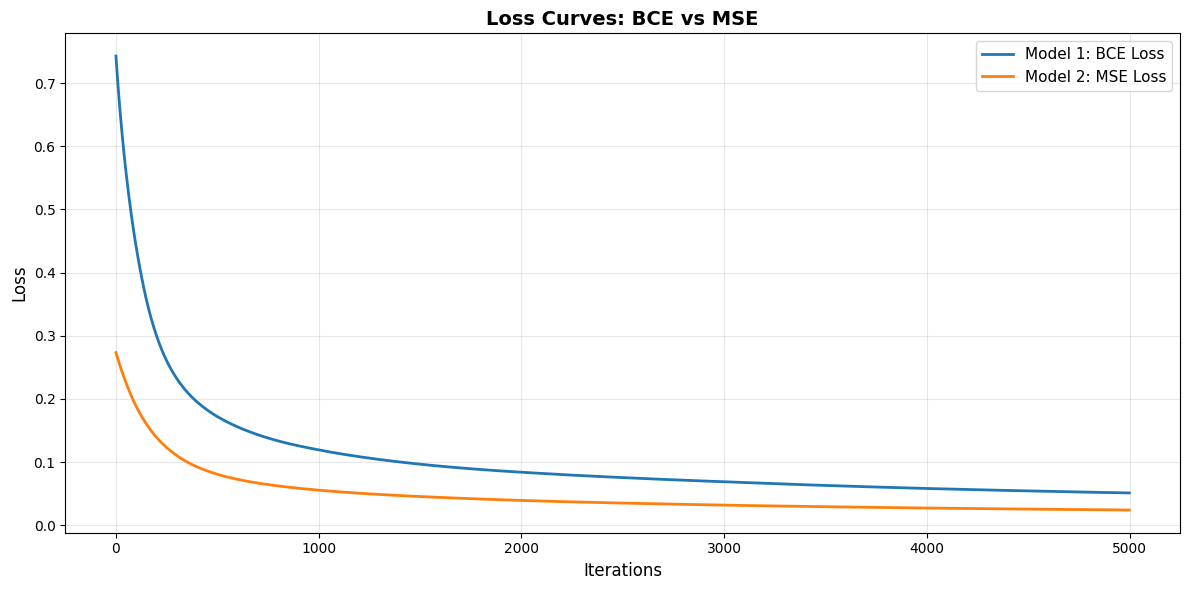

Loss curves plotted successfully!


In [22]:
# Plot loss curves for Model 1 (BCE) and Model 2 (MSE)
plt.figure(figsize=(12, 6))

plt.plot(model1.costs, label='Model 1: BCE Loss', linewidth=2)
plt.plot(model2.costs, label='Model 2: MSE Loss', linewidth=2)

plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curves: BCE vs MSE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Loss curves plotted successfully!")

## Summary: Model Comparison Table

In [23]:
# Create a comprehensive comparison table
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

models = [
    ("MyANN (BCE, 1 hidden layer)", y_pred_model1),
    ("MyANN (MSE, 1 hidden layer)", y_pred_model2),
    ("MyANN (BCE, 2 hidden layers)", y_pred_model3),
    ("sklearn MLPClassifier", y_pred_sklearn)
]

print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(f"{'Model':<35} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 100)

for model_name, y_pred in models:
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
    
    print(f"{model_name:<35} {accuracy:<12.4f} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

print("=" * 100)


COMPREHENSIVE MODEL COMPARISON
Model                               Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------------------
MyANN (BCE, 1 hidden layer)         0.9883       0.9907       0.9907       0.9907      
MyANN (MSE, 1 hidden layer)         0.9825       0.9907       0.9815       0.9860      
MyANN (BCE, 2 hidden layers)        0.9708       0.9813       0.9722       0.9767      
sklearn MLPClassifier               0.9825       0.9907       0.9815       0.9860      
